# SWB Regression Pipeline - Theta CPE Only Models
Created: 09/30/2024 \
Updated: 10/01/2024 \
*ran with 1 sec regression dfs from 09/25/2024*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
# from sklearn.linear_model import RANSACRegressor
# from sklearn.metrics import r2_score, mean_squared_error



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/bandpow_encoding_models/'
fig_dir    = f'{base_dir}figs/bandpow_regressions/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)



10012024


In [4]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


# Load beta power data 

In [8]:
epoch_len = '1sec'

In [9]:
band = 'theta' 
theta_df = pd.read_csv(f'{save_dir}regression_dfs/{band}_master_df_{epoch_len}.csv')
theta_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [10]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [11]:
roi_reref_labels_master_df.roi.value_counts()

roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [12]:
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()

keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     
keep_rois


['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [13]:
# ####### NEW DATA FRAME 
theta_reg_df = theta_df.copy()
theta_reg_df = theta_reg_df[theta_reg_df.roi.isin(keep_rois)]

# Test Single Electrode Regressions 

In [14]:
elec_col    = 'unique_reref_ch'
main_var    = 'cpe'
# reg_formula = 'band_pow~GambleChoice+TotalProfit+cpe'
reg_formula = 'band_pow~GambleChoice+TrialEV+cpe'

n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(theta_reg_df,reg_formula,elec_col, main_var,n_permutations)



Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2912.95it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2854.97it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3034.71it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2950.48it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2953.41it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2882.30it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2930.59it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2954.26it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2932.67it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2946.90it/s]


In [15]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TrialEV', 'cpe']

In [16]:
results = single_elec_permutation_results(results_dict,theta_reg_df,save_vars)
results

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TrialEV,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TrialEV,Permuted_Std_cpe,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TrialEV,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TrialEV,P_Value_cpe
0,MS002_lacas1-lacas2,MS002,acc,14,0.178282,-0.120838,-0.013575,0.021376,0.097131,-0.004052,...,0.077590,0.072540,1.406608,-1.406213,-0.118804,0.251827,0.159544,0.159661,0.905431,0.801174
1,MS002_lacas2-lacas3,MS002,acc,14,0.033429,0.089781,-0.007261,0.075003,0.094042,0.001884,...,0.090375,0.089460,-0.920478,0.927175,-0.061210,0.867800,0.357323,0.353836,0.951192,0.385504
2,MS002_lacas3-lacas4,MS002,acc,14,0.100253,0.026099,-0.128263,-0.041046,0.117813,0.000461,...,0.077884,0.073809,-0.319645,0.324181,-1.616289,-0.578933,0.749237,0.745801,0.106032,0.562635
3,MS002_lacas4-lacas5,MS002,acc,14,0.075507,0.031335,0.141511,0.010082,0.094090,0.005164,...,0.084325,0.084097,-0.299262,0.292652,1.646505,0.119455,0.764740,0.769788,0.099660,0.904915
4,MS002_lacas5-lacas6,MS002,acc,14,0.151994,0.041456,0.043684,0.009587,0.179991,0.001279,...,0.087375,0.083905,-0.430522,0.429104,0.535529,0.101200,0.666816,0.667848,0.592284,0.919391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,DA039_rpins1-rpins2,DA039,pins,22,0.145607,-0.003699,0.050519,-0.077619,0.146065,-0.001180,...,0.097272,0.082926,-0.010504,-0.024482,0.482231,-0.910267,0.991619,0.980468,0.629642,0.362682
1184,DA039_rpins2-rpins3,DA039,pins,22,-0.051109,0.168455,0.216447,0.024138,0.029335,-0.003586,...,0.082714,0.070630,-2.307096,2.104300,2.677562,0.315481,0.021049,0.035352,0.007416,0.752396
1185,DA039_rpins3-rpins4,DA039,pins,22,-0.009005,0.020496,-0.037638,-0.009052,-0.002958,0.000308,...,0.077975,0.067288,-0.182097,0.258855,-0.463293,-0.121523,0.855506,0.795747,0.643154,0.903277
1186,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.113534,0.116915,-0.037591,-0.030265,-0.070129,0.001539,...,0.077839,0.063453,-1.300185,1.474078,-0.531597,-0.485730,0.193537,0.140461,0.595005,0.627158


### Save results as pickle file

In [17]:
save_path = f'{save_dir}/{band}/'
os.makedirs(save_path, exist_ok=True)

fname = f'{save_path}{band}_perm_regression_results_cpe-only_model_{date}.pkl'
pickle.dump(results, open(fname,"wb"))

In [18]:
sig_data = results[results.P_Value_cpe < 0.05]
sig_data



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TrialEV,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TrialEV,Permuted_Std_cpe,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TrialEV,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TrialEV,P_Value_cpe
22,MS002_lhplt1-lhplt2,MS002,hpc,14,-0.052925,0.200351,0.117224,0.212338,0.082933,0.003689,...,0.085558,0.077813,-2.141218,2.152454,1.350678,2.769782,0.032256,0.031362,0.176799,0.005609
26,MS002_lloif1-lloif2,MS002,ofc,14,0.295279,-0.070832,0.073507,0.195384,0.246848,-0.001968,...,0.091638,0.091722,0.715586,-0.706783,0.796501,2.119625,0.474247,0.479701,0.425741,0.034038
36,MS002_lmoif11-lmoif12,MS002,vlpfc,14,0.005906,-0.006091,-0.026910,0.149162,-0.000170,0.001558,...,0.065329,0.062227,0.121919,-0.106610,-0.393552,2.375489,0.902963,0.915098,0.693912,0.017526
48,MS002_racas1-racas2,MS002,acc,14,-0.020995,0.037034,0.121036,0.167889,0.004520,-0.000231,...,0.065832,0.064164,-0.509983,0.517293,1.869095,2.569769,0.610063,0.604952,0.061610,0.010177
51,MS002_racas6-racas7,MS002,dmpfc,14,0.074063,0.128051,-0.045131,0.223395,0.165521,-0.005469,...,0.091113,0.085866,-1.390868,1.409977,-0.497483,2.617812,0.164265,0.158546,0.618849,0.008850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,DA039_rains3-rains4,DA039,ains,22,-0.111105,0.175318,0.016879,-0.199505,-0.044749,0.004712,...,0.094468,0.079496,-1.624959,1.775473,0.189430,-2.453851,0.104171,0.075820,0.849756,0.014134
1160,DA039_rains4-rains5,DA039,ains,22,-0.052222,0.041772,0.084228,-0.158460,-0.032785,-0.001028,...,0.089241,0.074857,-0.492619,0.460794,0.956609,-2.118620,0.622282,0.644946,0.338765,0.034123
1172,DA039_rof1-rof2,DA039,ofc,22,-0.117639,0.115311,-0.032195,-0.165554,-0.074629,-0.002326,...,0.075804,0.062278,-1.293099,1.502204,-0.437340,-2.602981,0.195977,0.133045,0.661865,0.009242
1179,DA039_rof8-rof9,DA039,dlpfc,22,0.036923,0.009339,0.229387,0.131823,0.055251,-0.001841,...,0.079565,0.065668,-0.529944,0.137563,2.906786,2.045026,0.596151,0.890586,0.003652,0.040852


In [19]:
sig_data.roi.value_counts()



roi
acc      16
dmpfc    14
ofc      14
hpc      11
dlpfc    10
ains      8
pins      5
vlpfc     4
amy       3
Name: count, dtype: int64

In [20]:
sig_data.roi.unique()



array(['hpc', 'ofc', 'vlpfc', 'acc', 'dmpfc', 'ains', 'pins', 'dlpfc',
       'amy'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [21]:
# add mask col for sig cpe elecs 
results['cpe_sig']   = results['P_Value_cpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TrialEV,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TrialEV,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TrialEV,P_Value_cpe,cpe_sig,bdi_split
0,MS002_lacas1-lacas2,MS002,acc,14,0.178282,-0.120838,-0.013575,0.021376,0.097131,-0.004052,...,1.406608,-1.406213,-0.118804,0.251827,0.159544,0.159661,0.905431,0.801174,0,0
1,MS002_lacas2-lacas3,MS002,acc,14,0.033429,0.089781,-0.007261,0.075003,0.094042,0.001884,...,-0.920478,0.927175,-0.061210,0.867800,0.357323,0.353836,0.951192,0.385504,0,0
2,MS002_lacas3-lacas4,MS002,acc,14,0.100253,0.026099,-0.128263,-0.041046,0.117813,0.000461,...,-0.319645,0.324181,-1.616289,-0.578933,0.749237,0.745801,0.106032,0.562635,0,0
3,MS002_lacas4-lacas5,MS002,acc,14,0.075507,0.031335,0.141511,0.010082,0.094090,0.005164,...,-0.299262,0.292652,1.646505,0.119455,0.764740,0.769788,0.099660,0.904915,0,0
4,MS002_lacas5-lacas6,MS002,acc,14,0.151994,0.041456,0.043684,0.009587,0.179991,0.001279,...,-0.430522,0.429104,0.535529,0.101200,0.666816,0.667848,0.592284,0.919391,0,0


In [22]:
cpe_var = 'Z_Score_cpe'

In [23]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [24]:
results.groupby('roi').agg('mean',numeric_only=True)[cpe_var][bar_order]



roi
dlpfc    0.007564
vlpfc   -0.000384
dmpfc   -0.111067
ofc     -0.195508
ains     0.260808
pins     0.277840
acc      0.165000
amy      0.090884
hpc     -0.318405
Name: Z_Score_cpe, dtype: float64

In [25]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[cpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.cpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].cpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [26]:
roi_sig_info

,roi,n_total,n_sig,prop_sig,n_sig_highbdi,ttest_stat,ttest_pval,binom_ci_low,binom_ci_high,binom_prop,binom_pval
0,acc,193,16,0.082902,4,2.023012,0.044459,0.052690,1.0,0.082902,0.0337
1,dmpfc,225,14,0.062222,2,-1.587928,0.113713,0.038006,1.0,0.062222,0.2380
2,amy,113,3,0.026549,1,1.010508,0.314430,0.007274,1.0,0.026549,0.9256
3,ains,71,8,0.112676,3,1.736270,0.086916,0.057316,1.0,0.112676,0.0252
4,vlpfc,82,4,0.048780,0,-0.003272,0.997398,0.016832,1.0,0.048780,0.5912
5,hpc,135,11,0.081481,0,-3.401120,0.000885,0.046366,1.0,0.081481,0.0765
6,ofc,202,14,0.069307,2,-2.660257,0.008438,0.042384,1.0,0.069307,0.1373
7,pins,60,5,0.083333,1,2.157388,0.035059,0.033411,1.0,0.083333,0.1803
8,dlpfc,107,10,0.093458,3,0.069793,0.944490,0.051584,1.0,0.093458,0.0420


In [27]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

,roi,n_total,n_sig,prop_sig,n_sig_highbdi,ttest_stat,ttest_pval,binom_ci_low,binom_ci_high,binom_prop,binom_pval
0,acc,193,16,0.082902,4,2.023012,0.044459,0.052690,1.0,0.082902,0.0337
3,ains,71,8,0.112676,3,1.736270,0.086916,0.057316,1.0,0.112676,0.0252
8,dlpfc,107,10,0.093458,3,0.069793,0.944490,0.051584,1.0,0.093458,0.0420


# Plot Results

In [28]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_cpe_only-coeff_barplot_{epoch_len}.pdf'


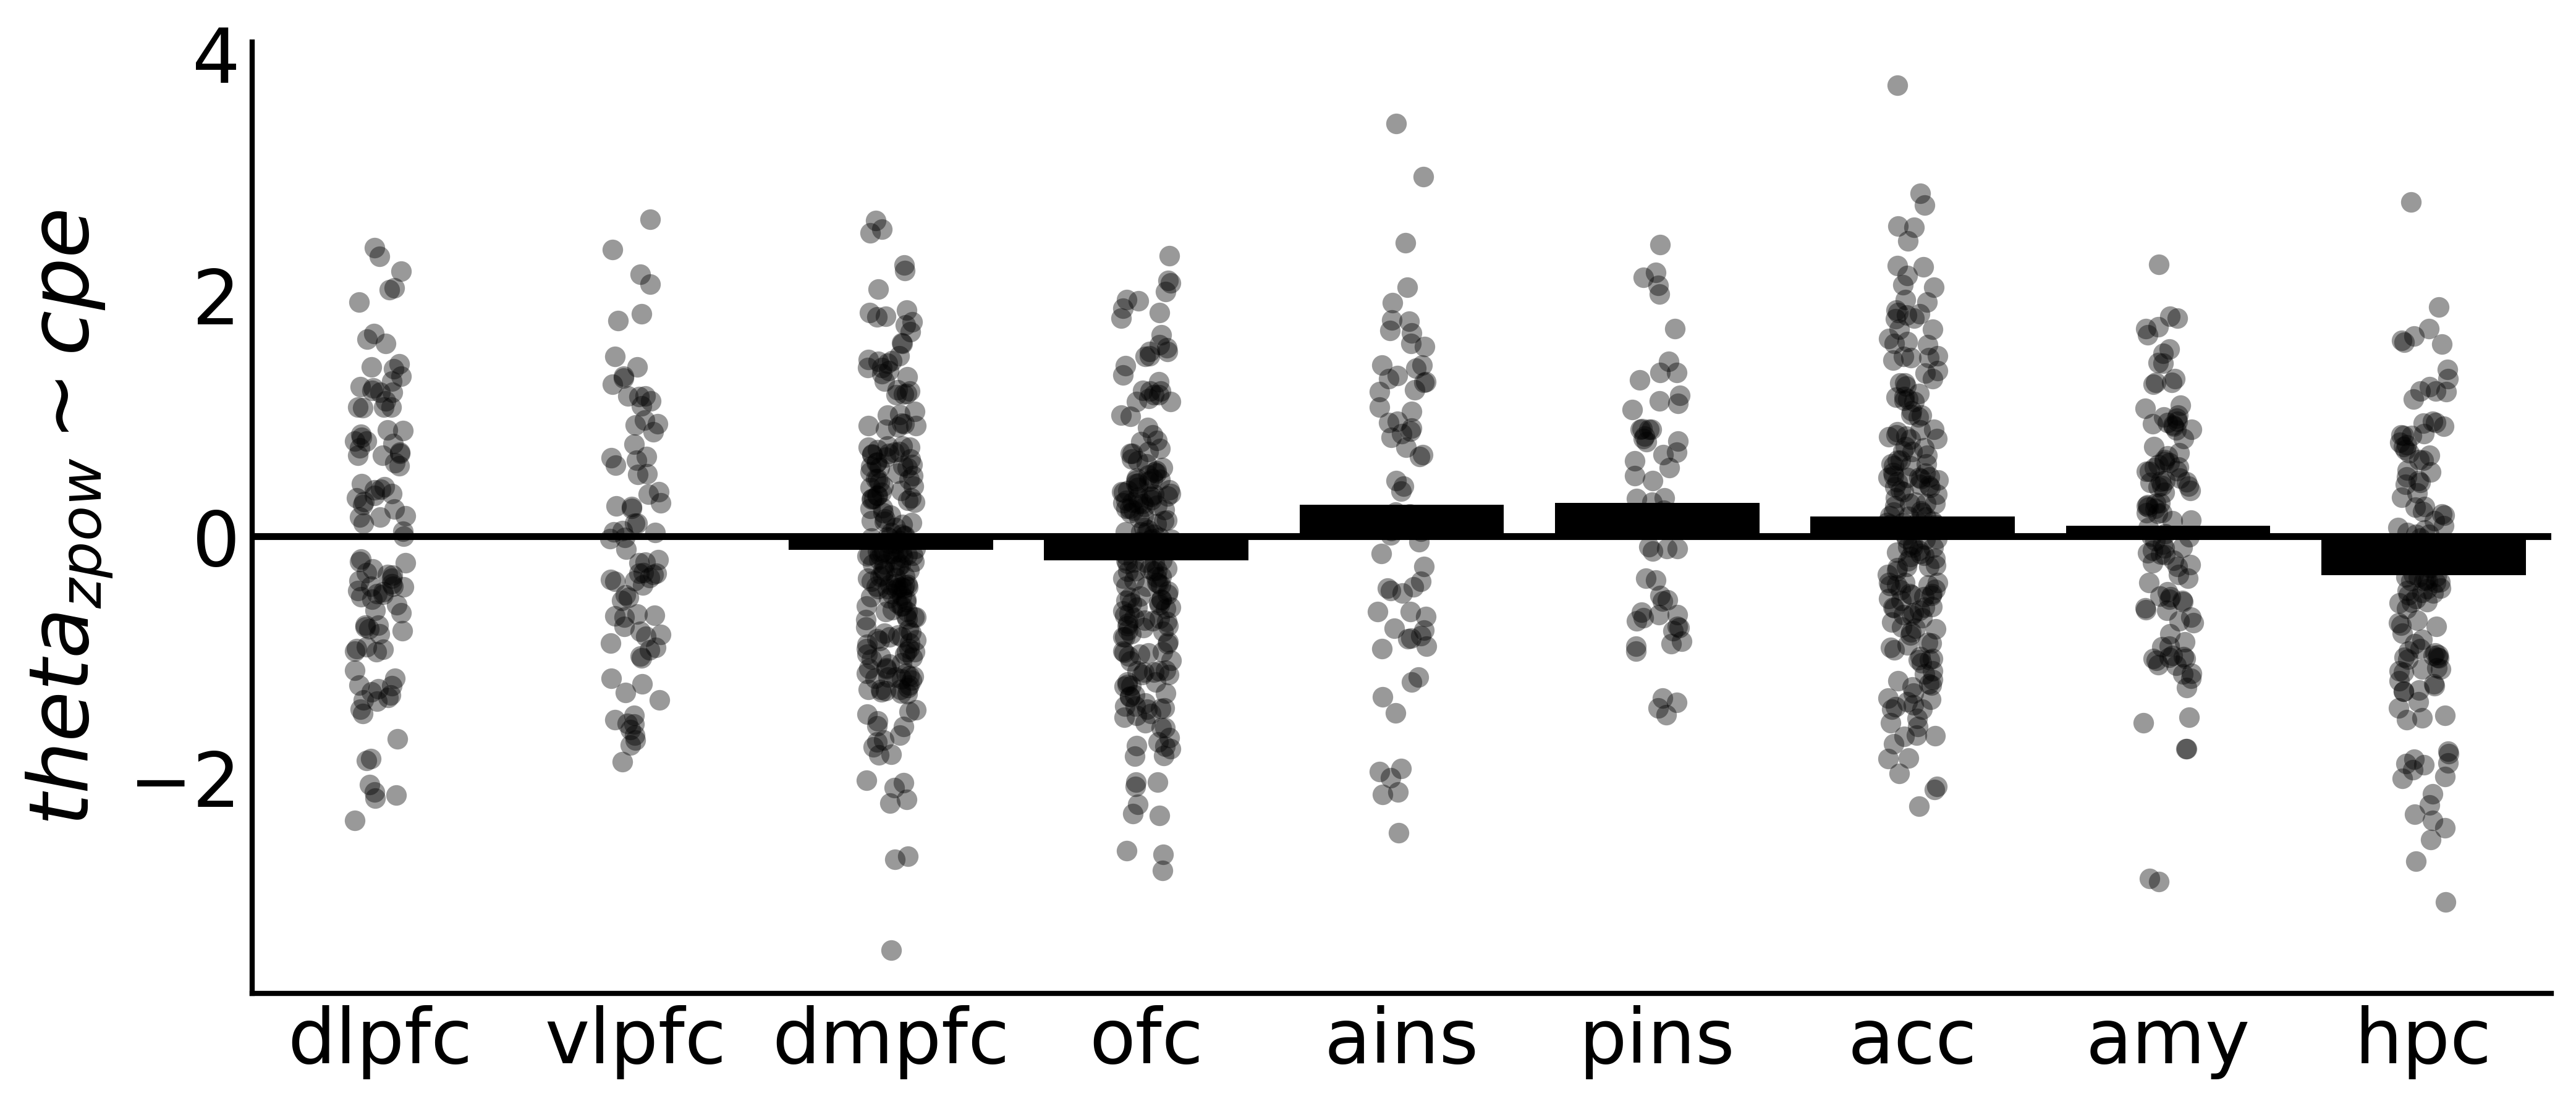

In [29]:
### WITHOUT RPE IN MODEL

ylabel = fr'${band}_{{zpow}} \sim cpe$'


plot_roi_model_results(results,'roi',cpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

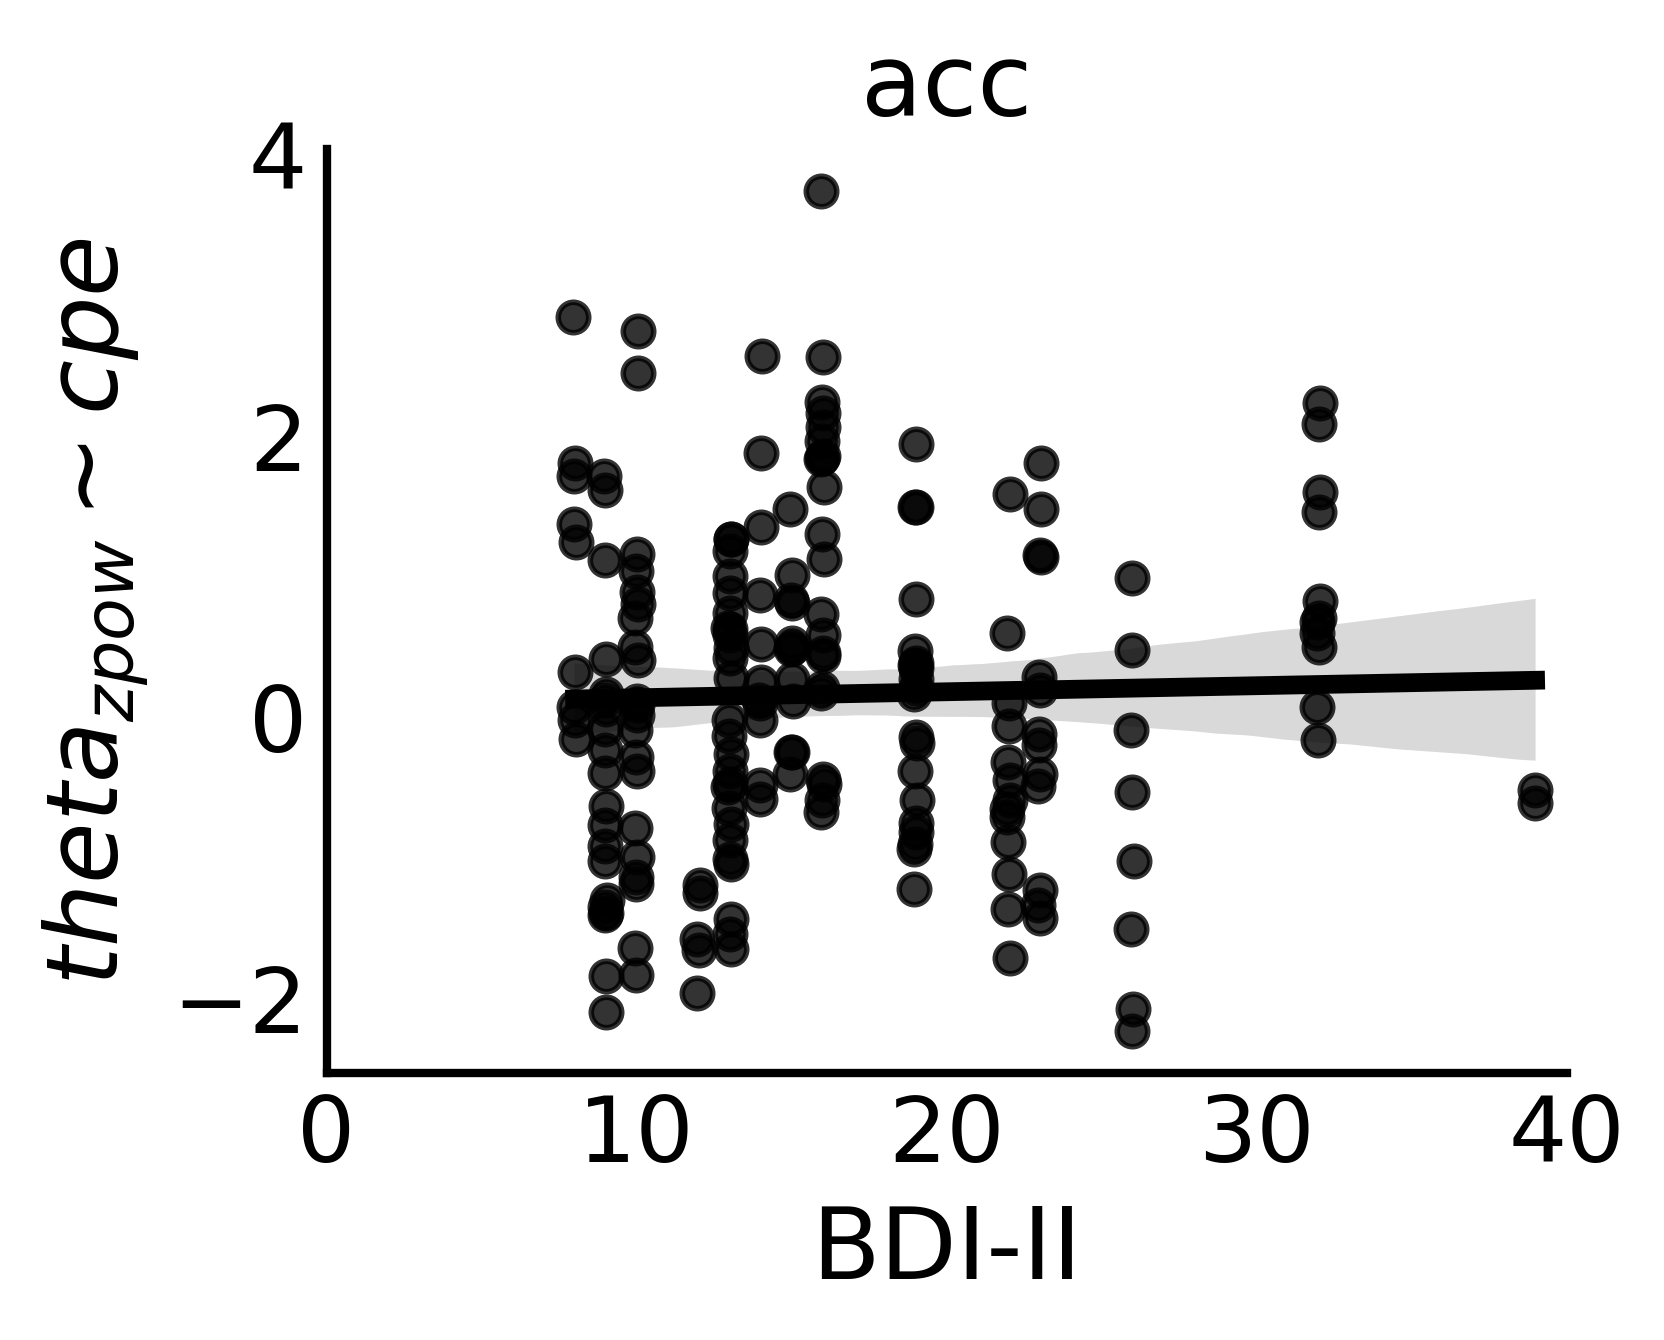

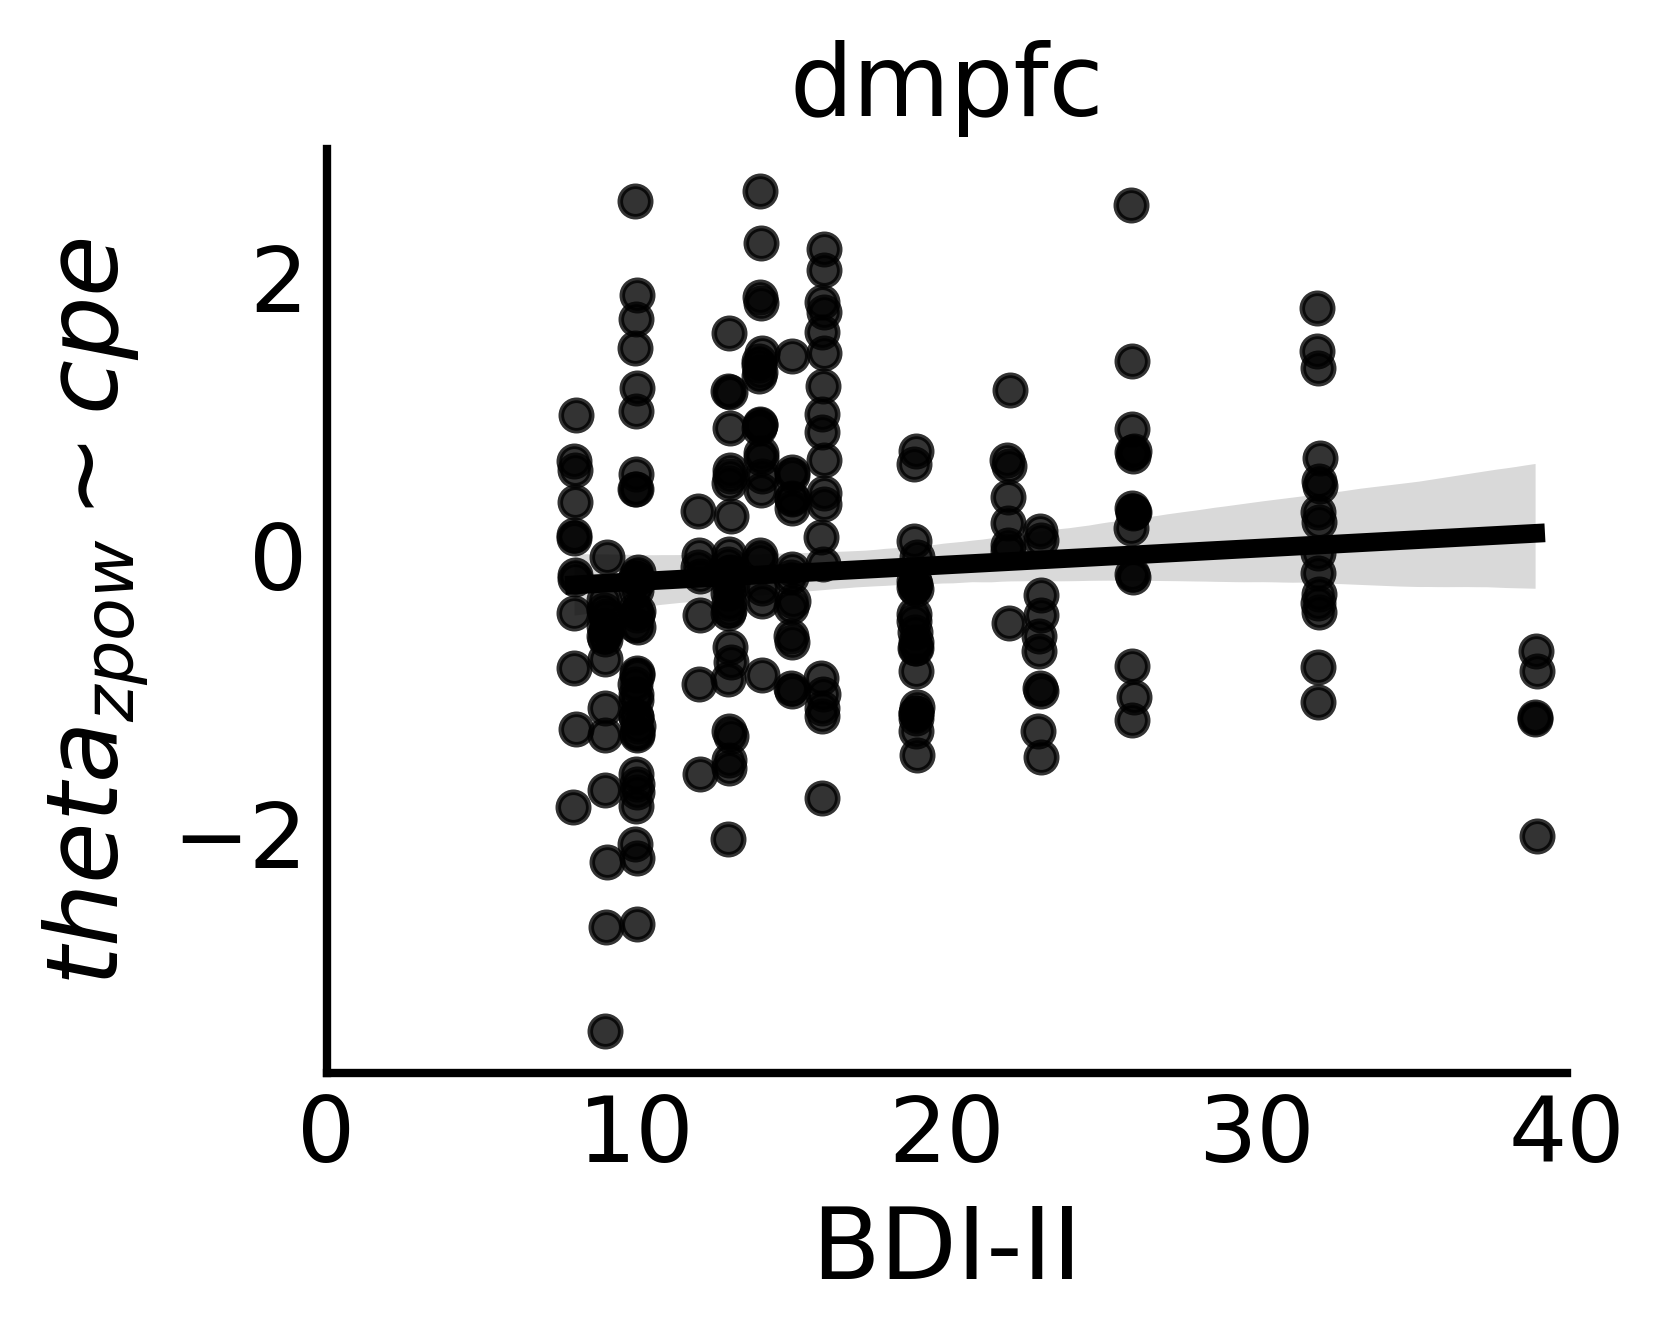

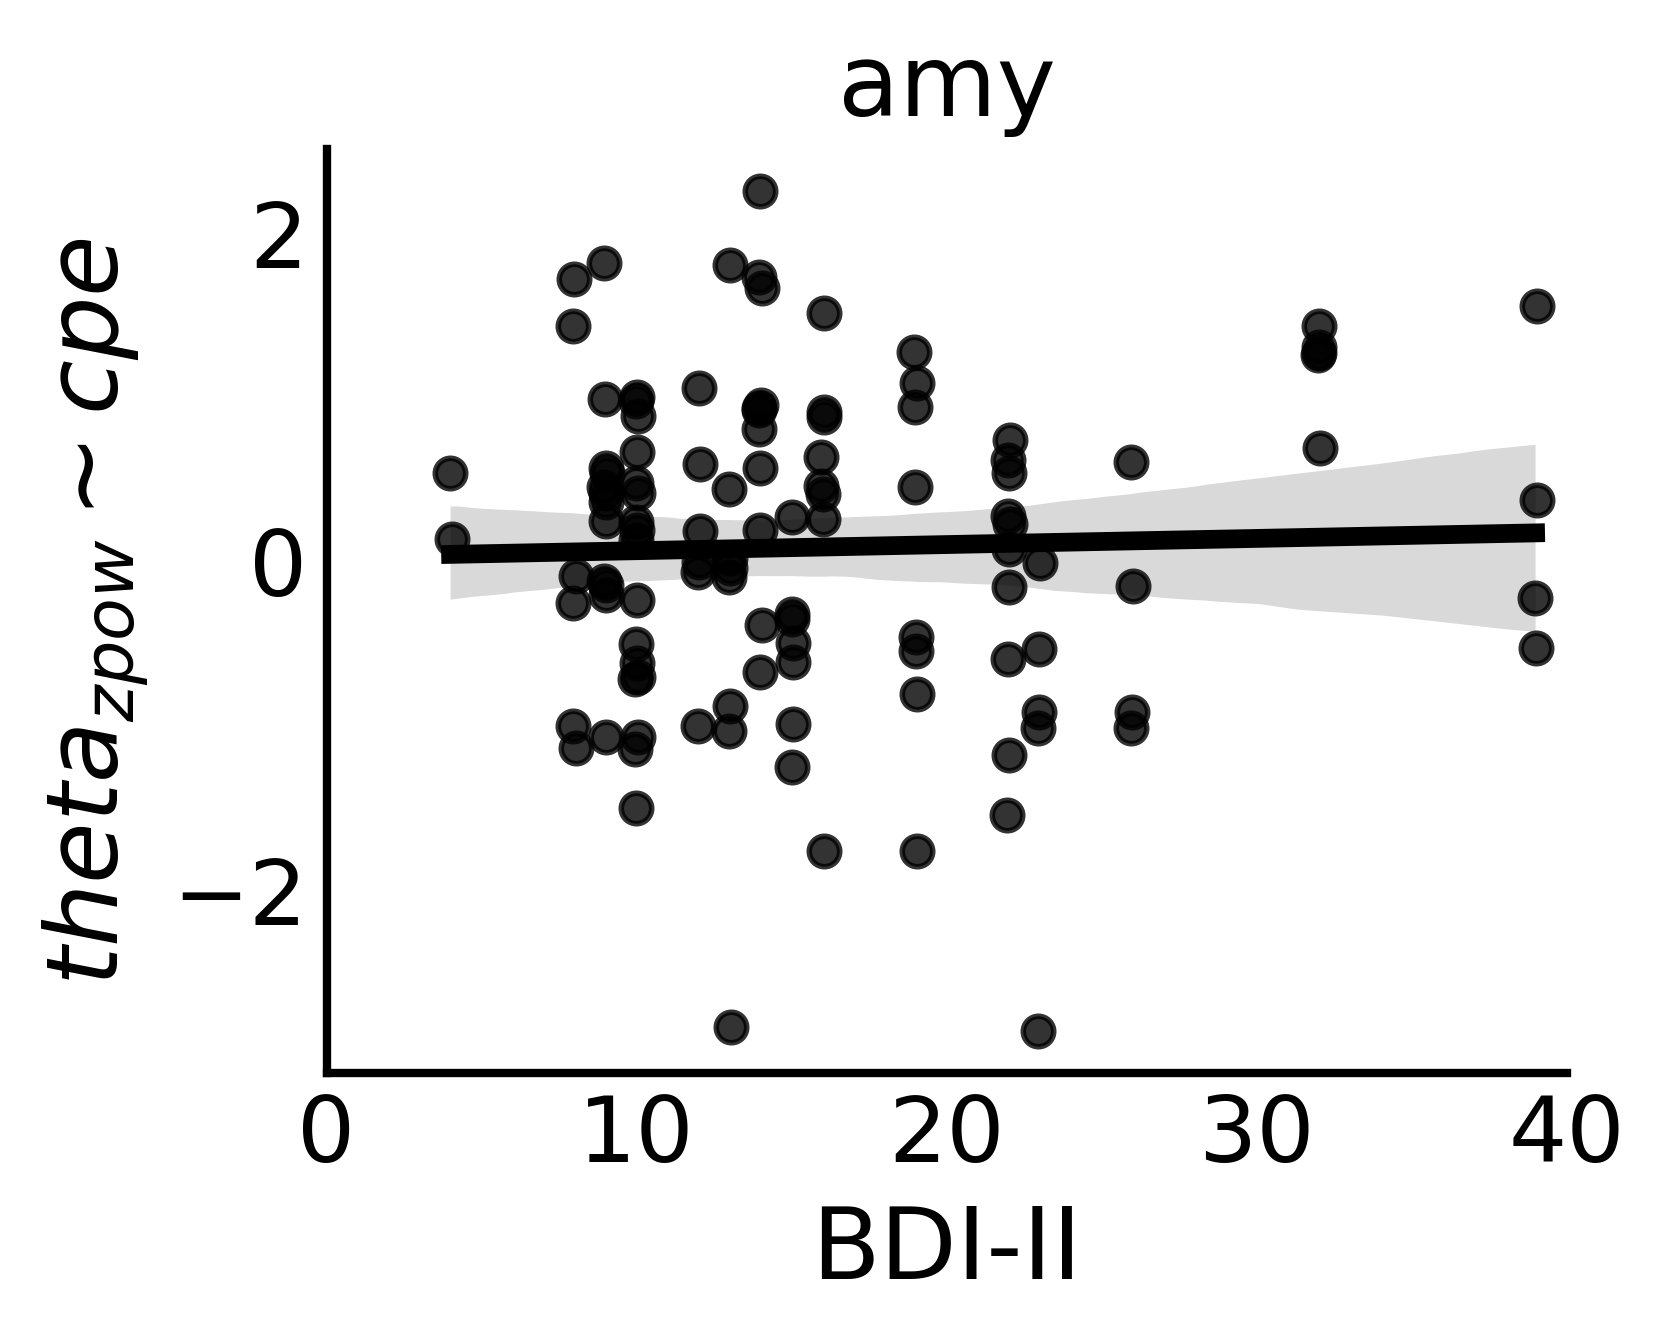

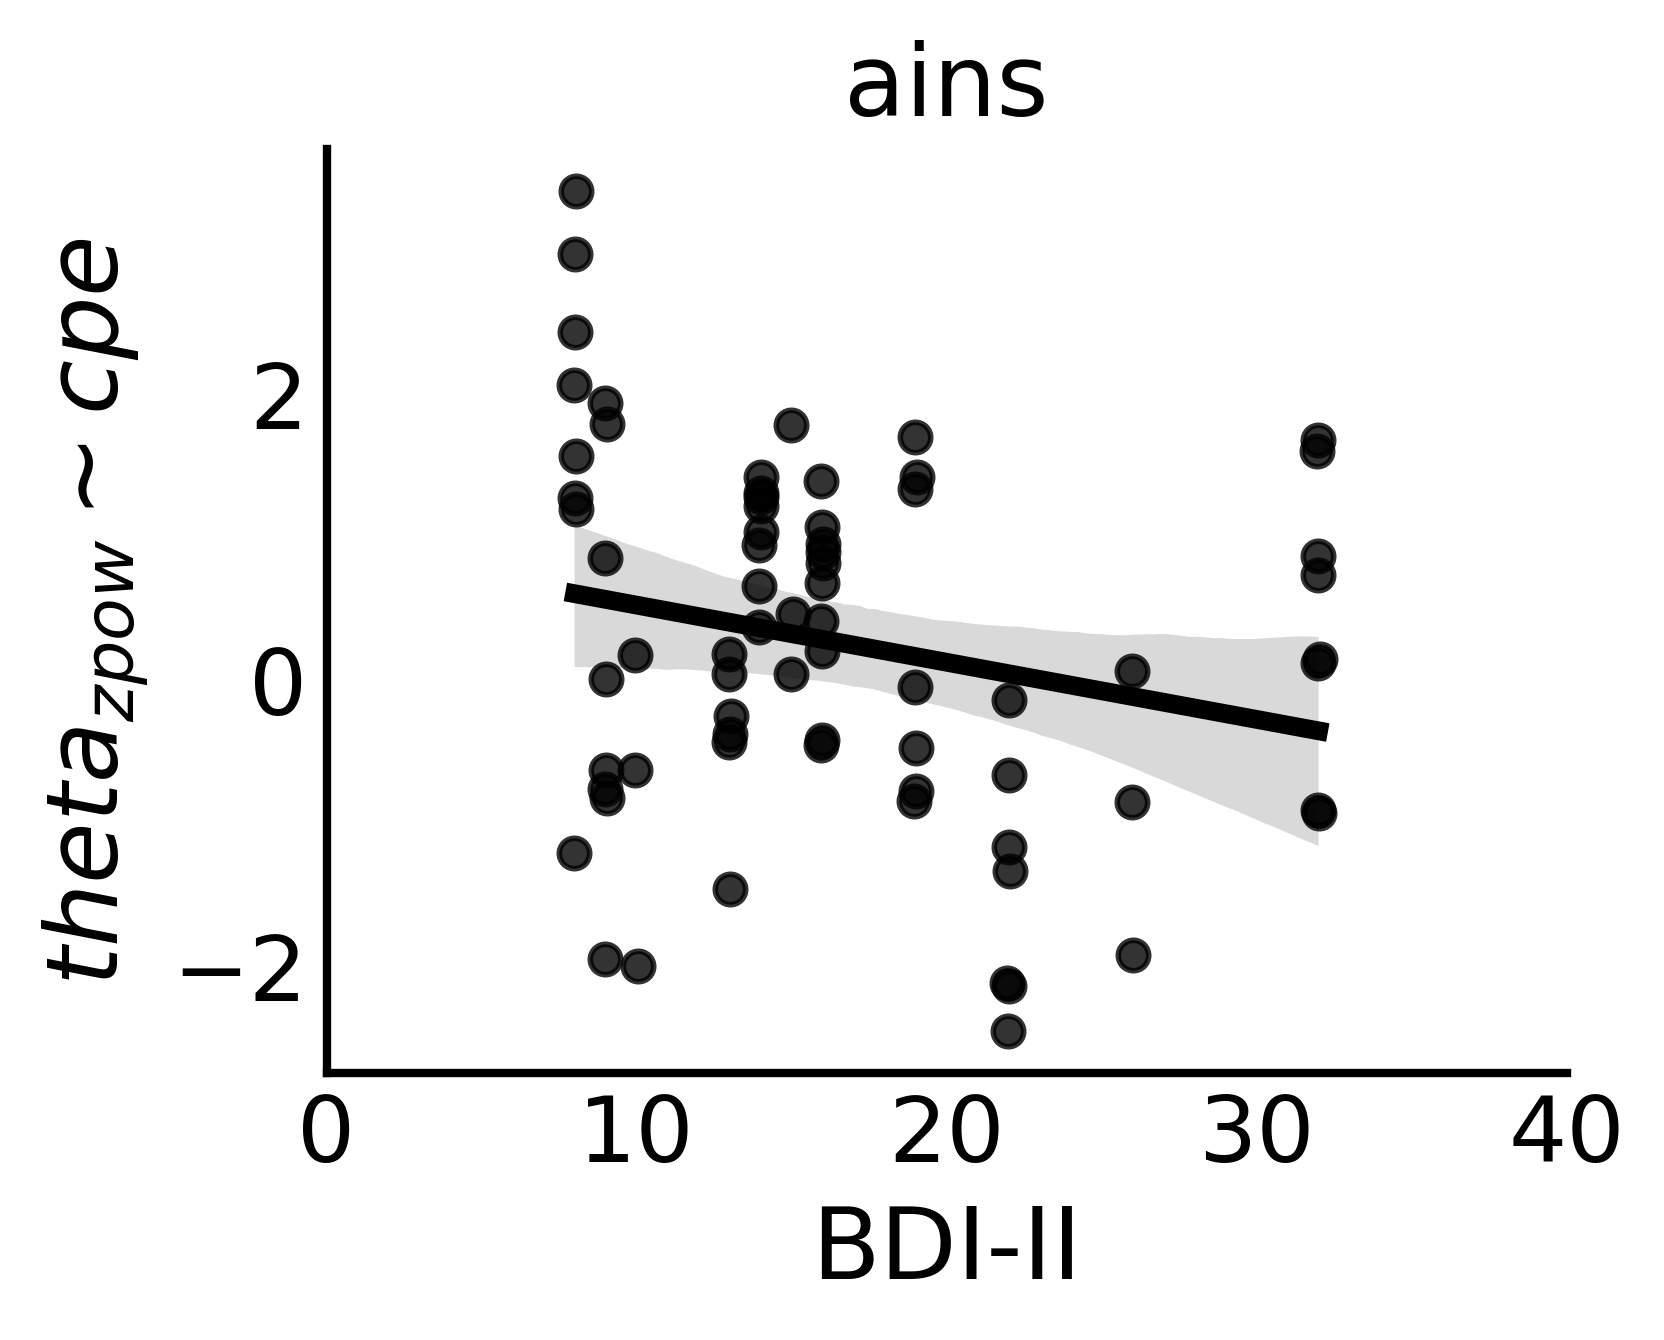

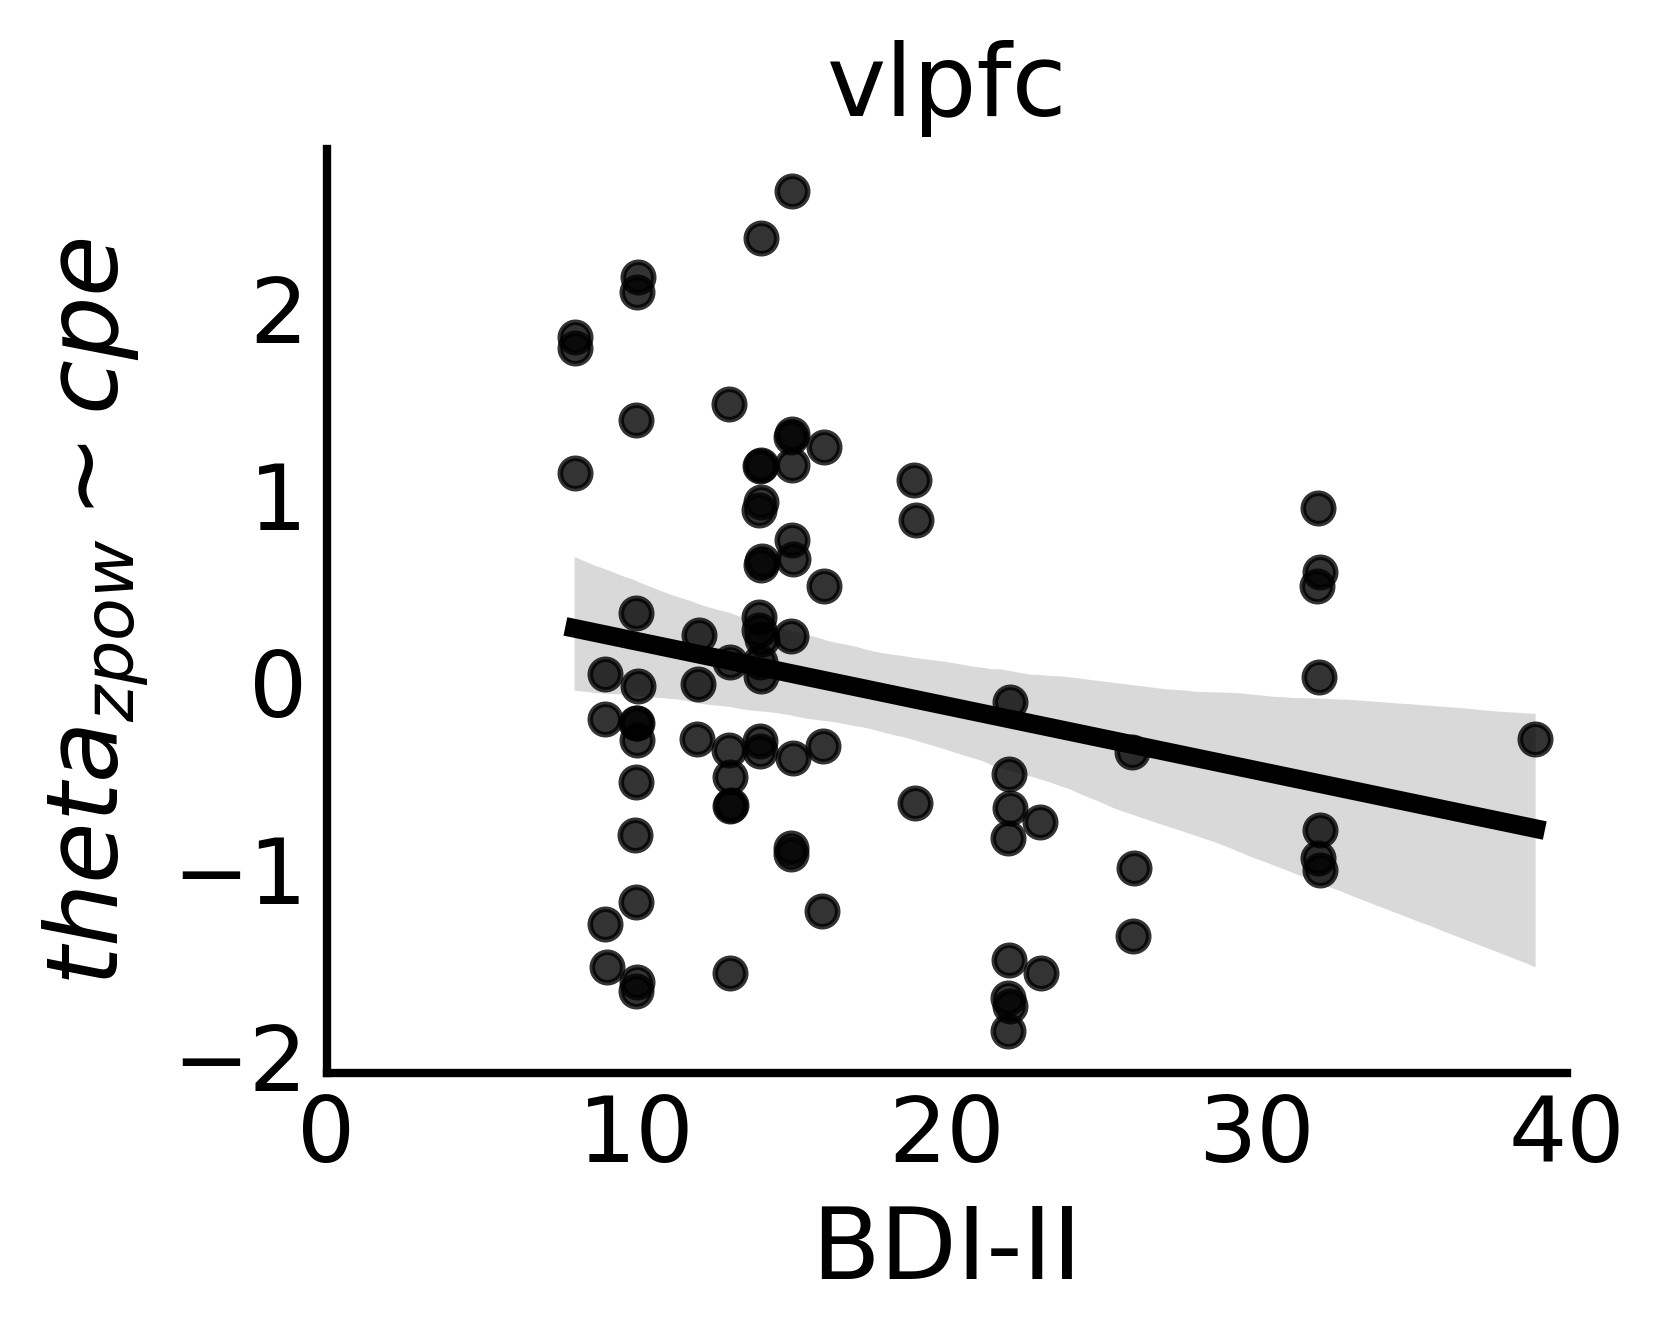

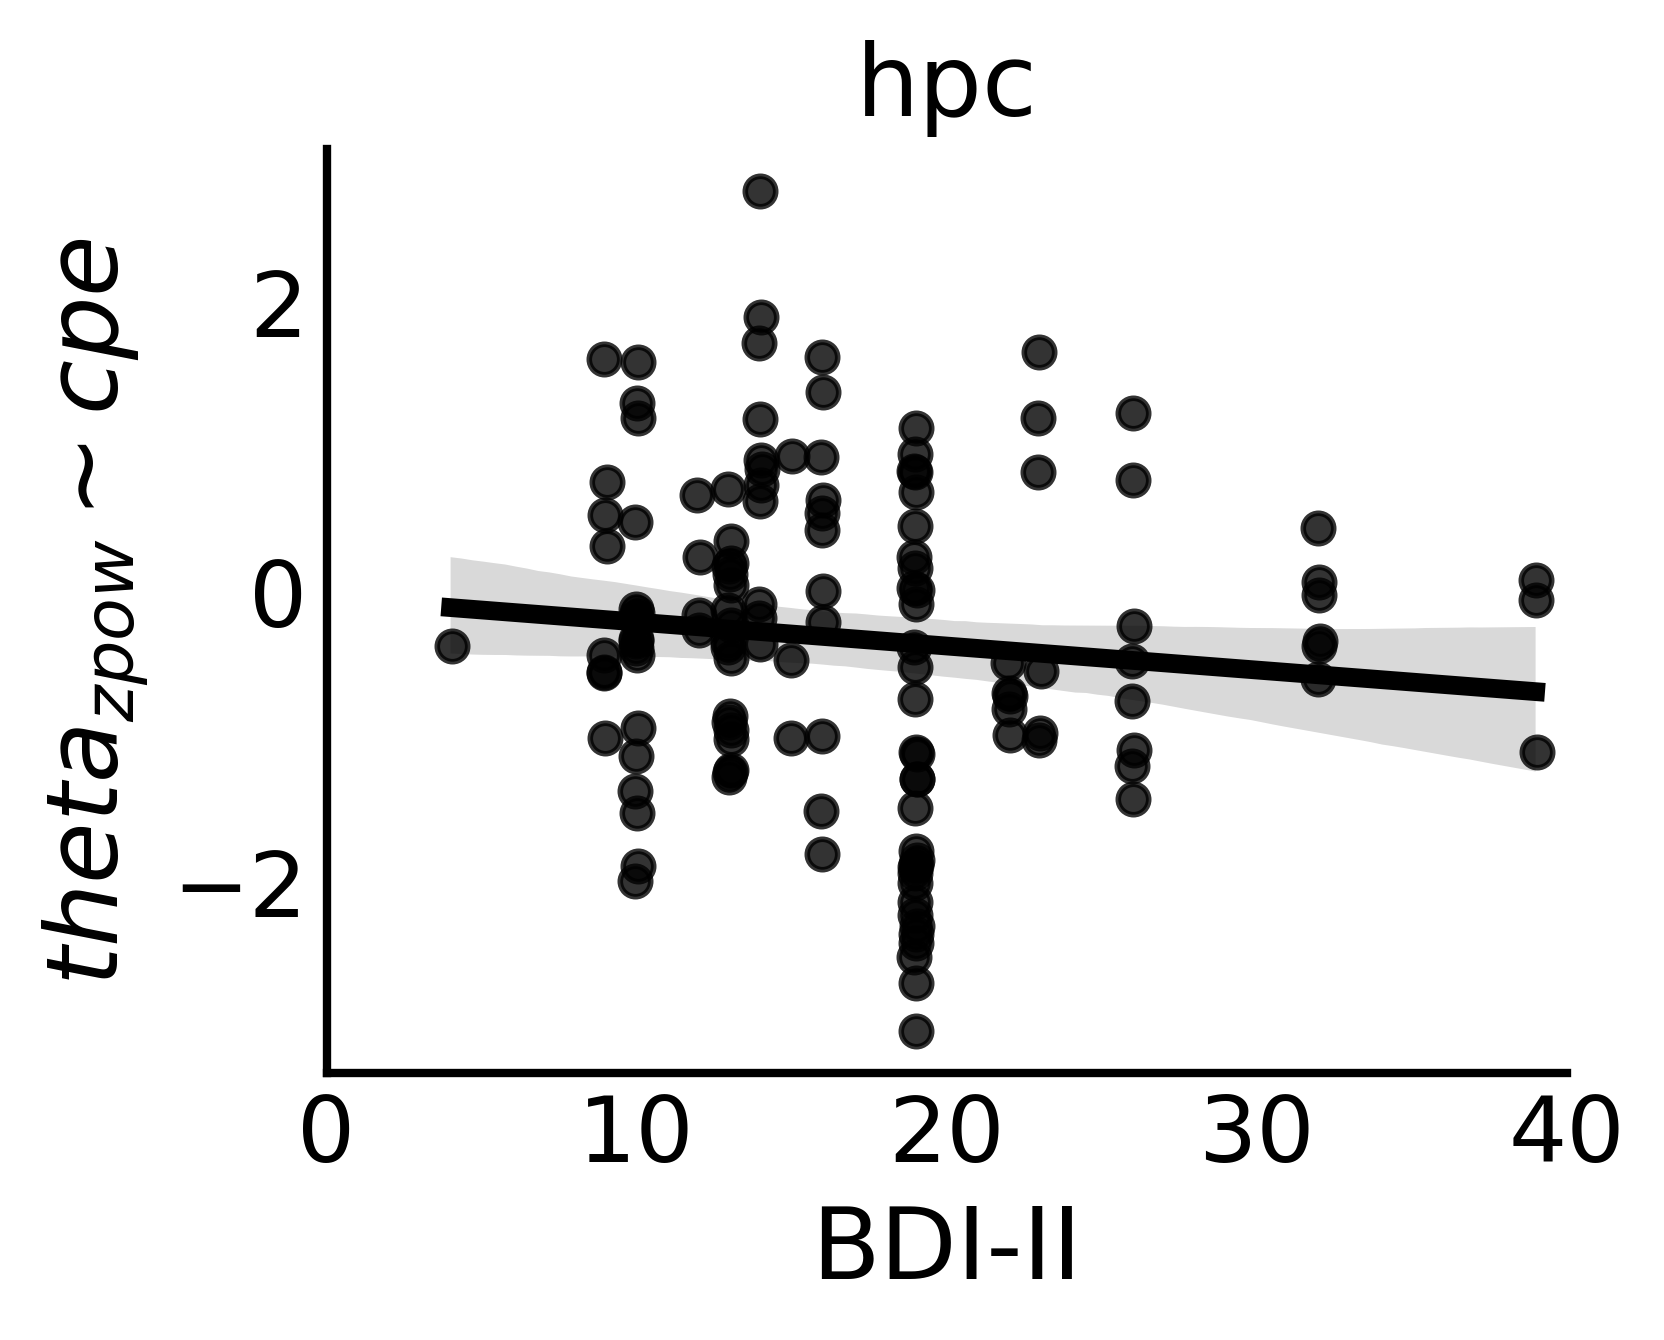

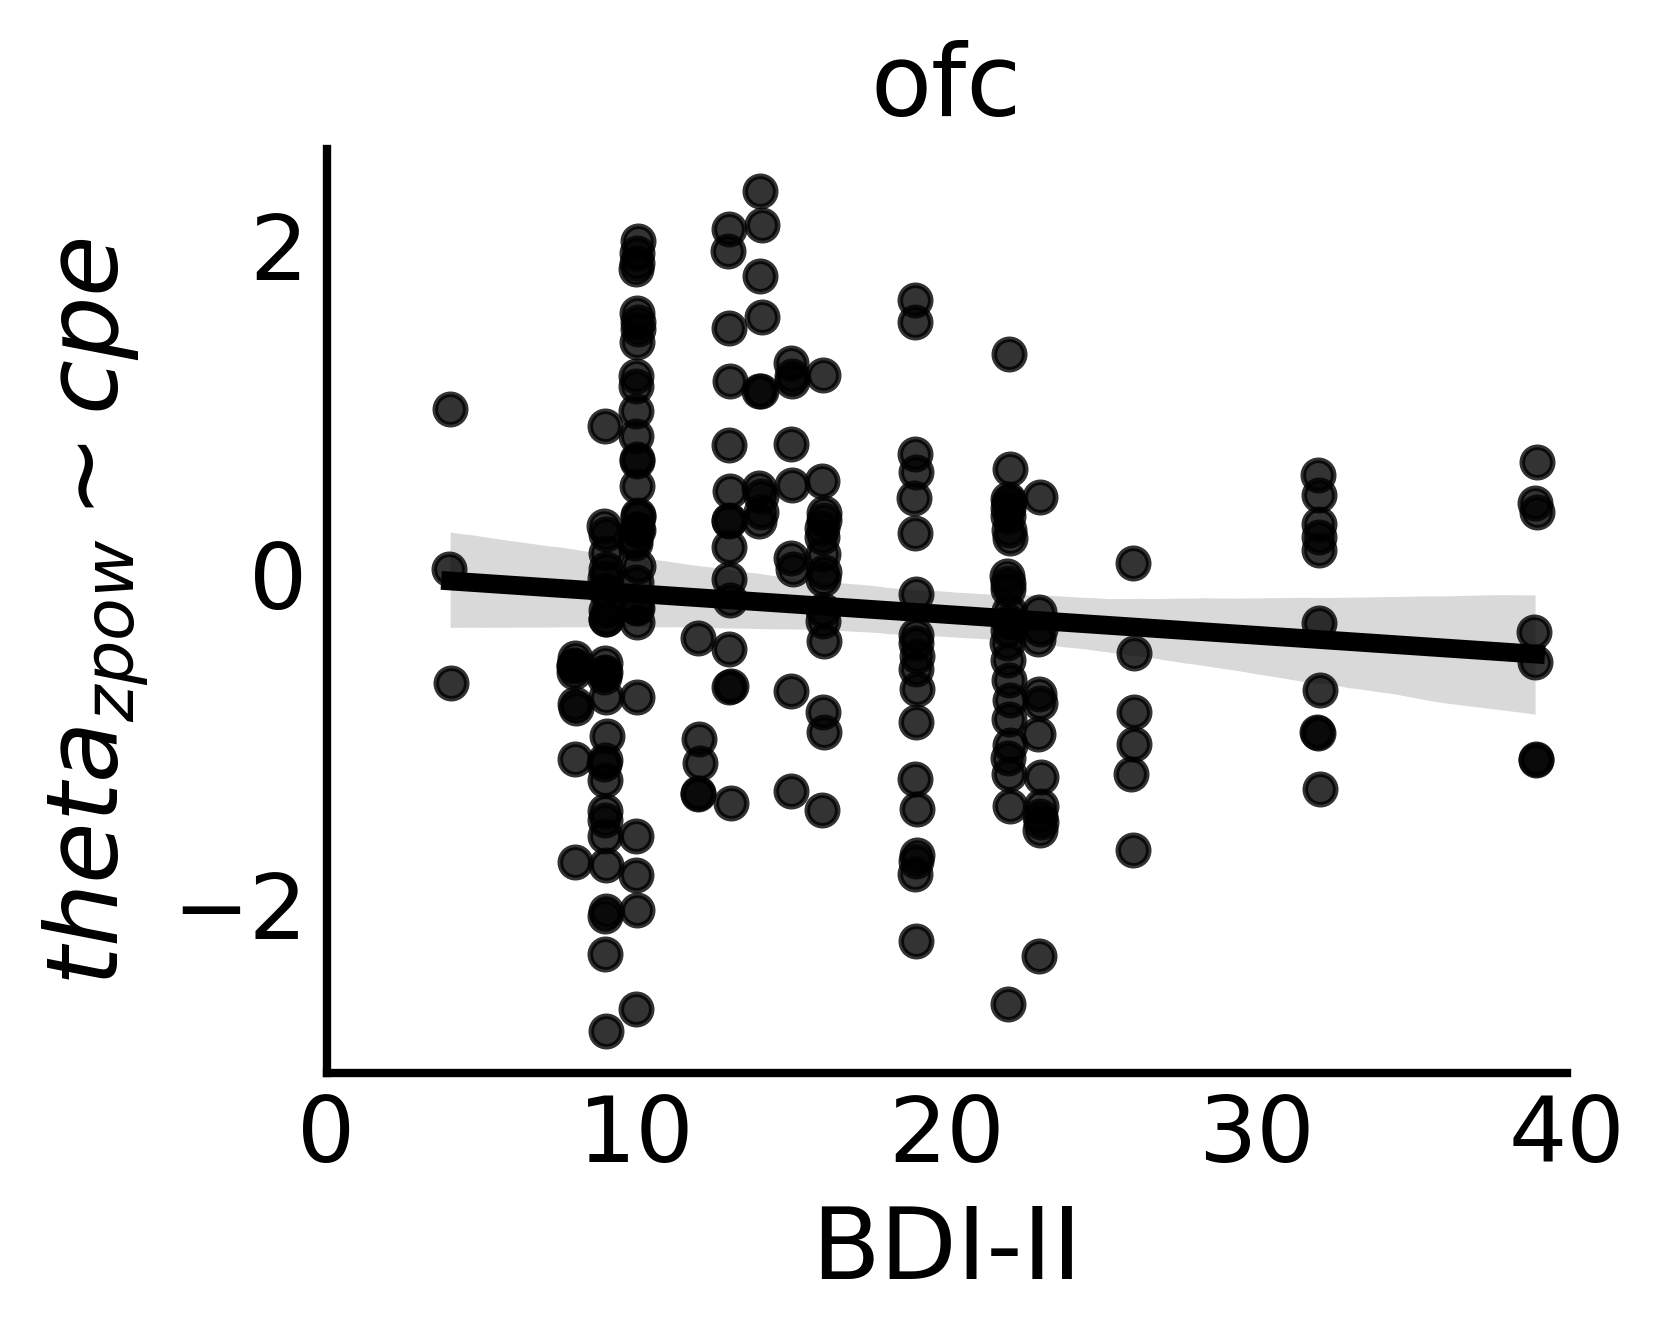

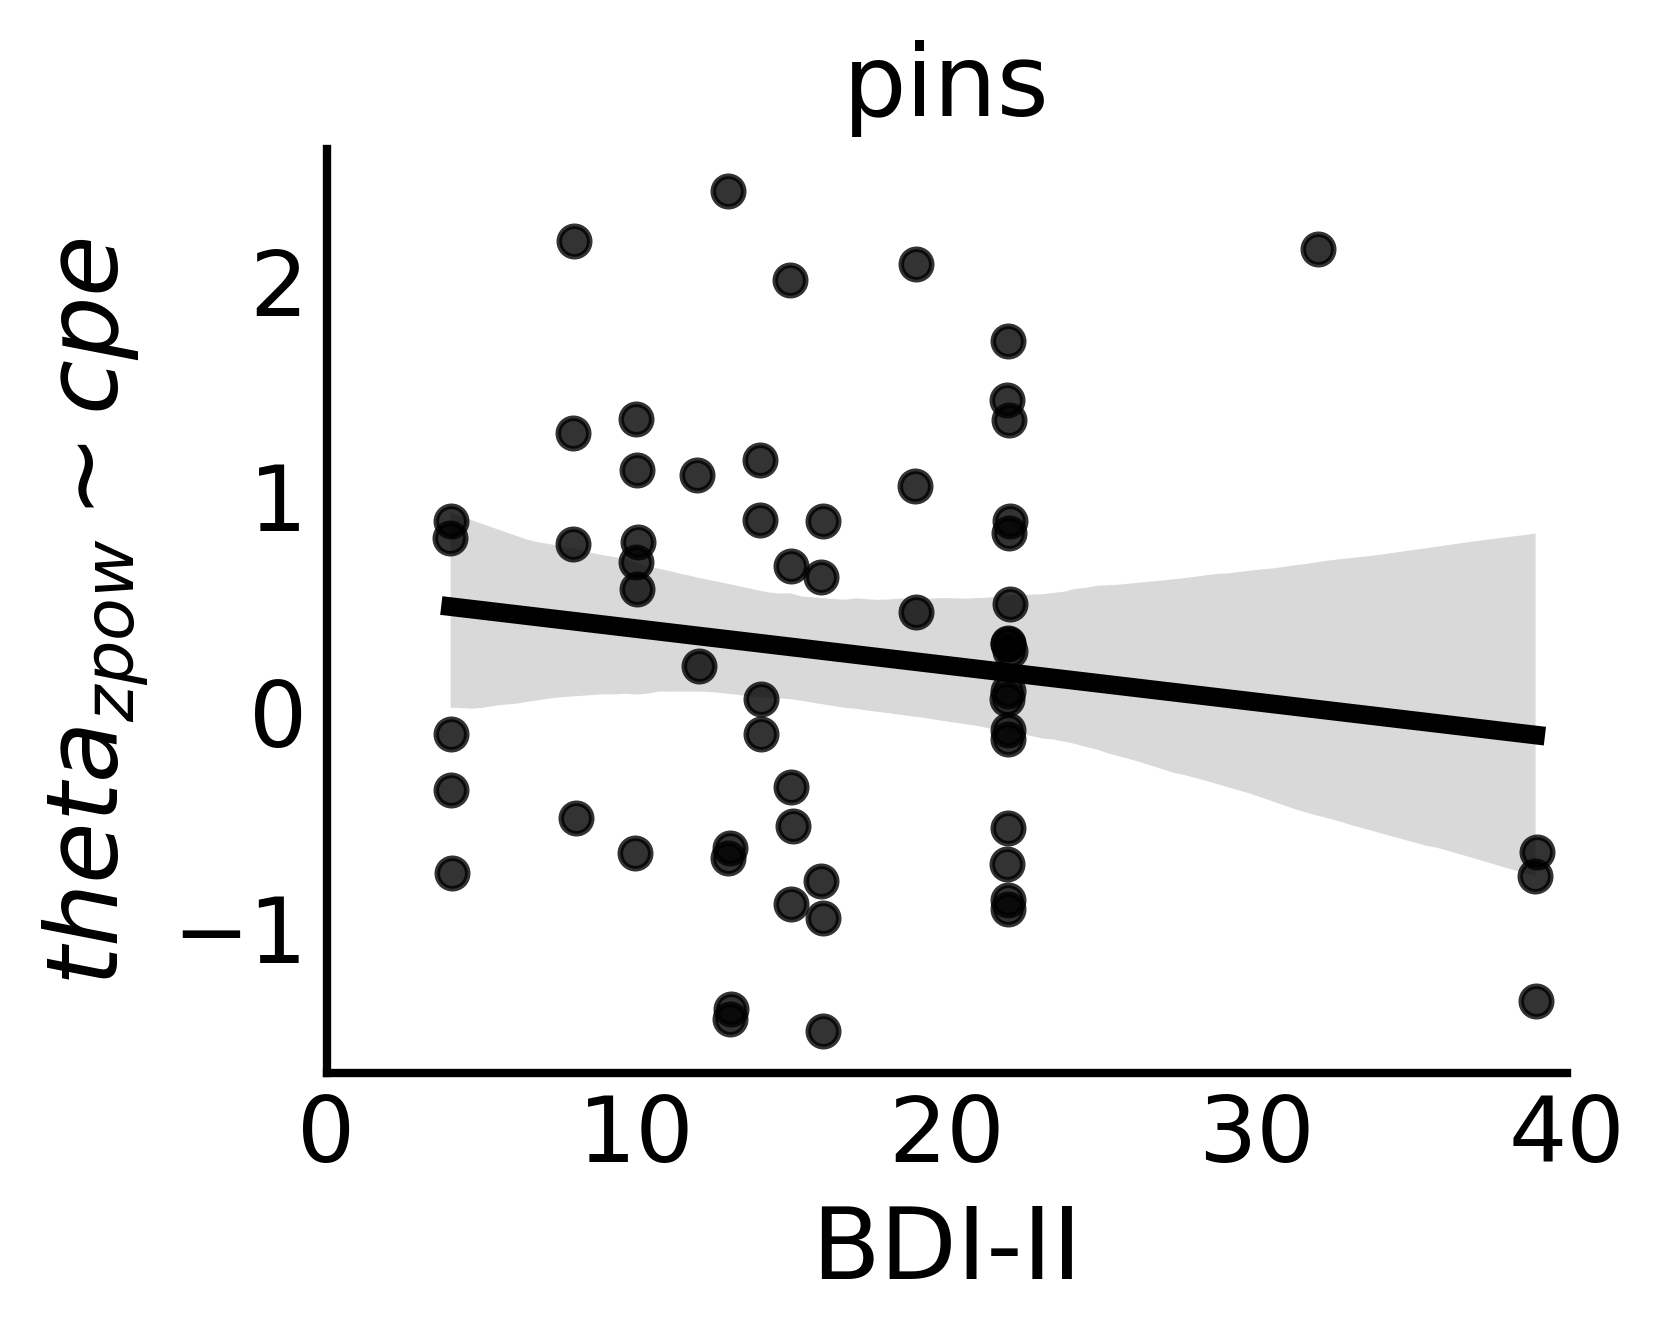

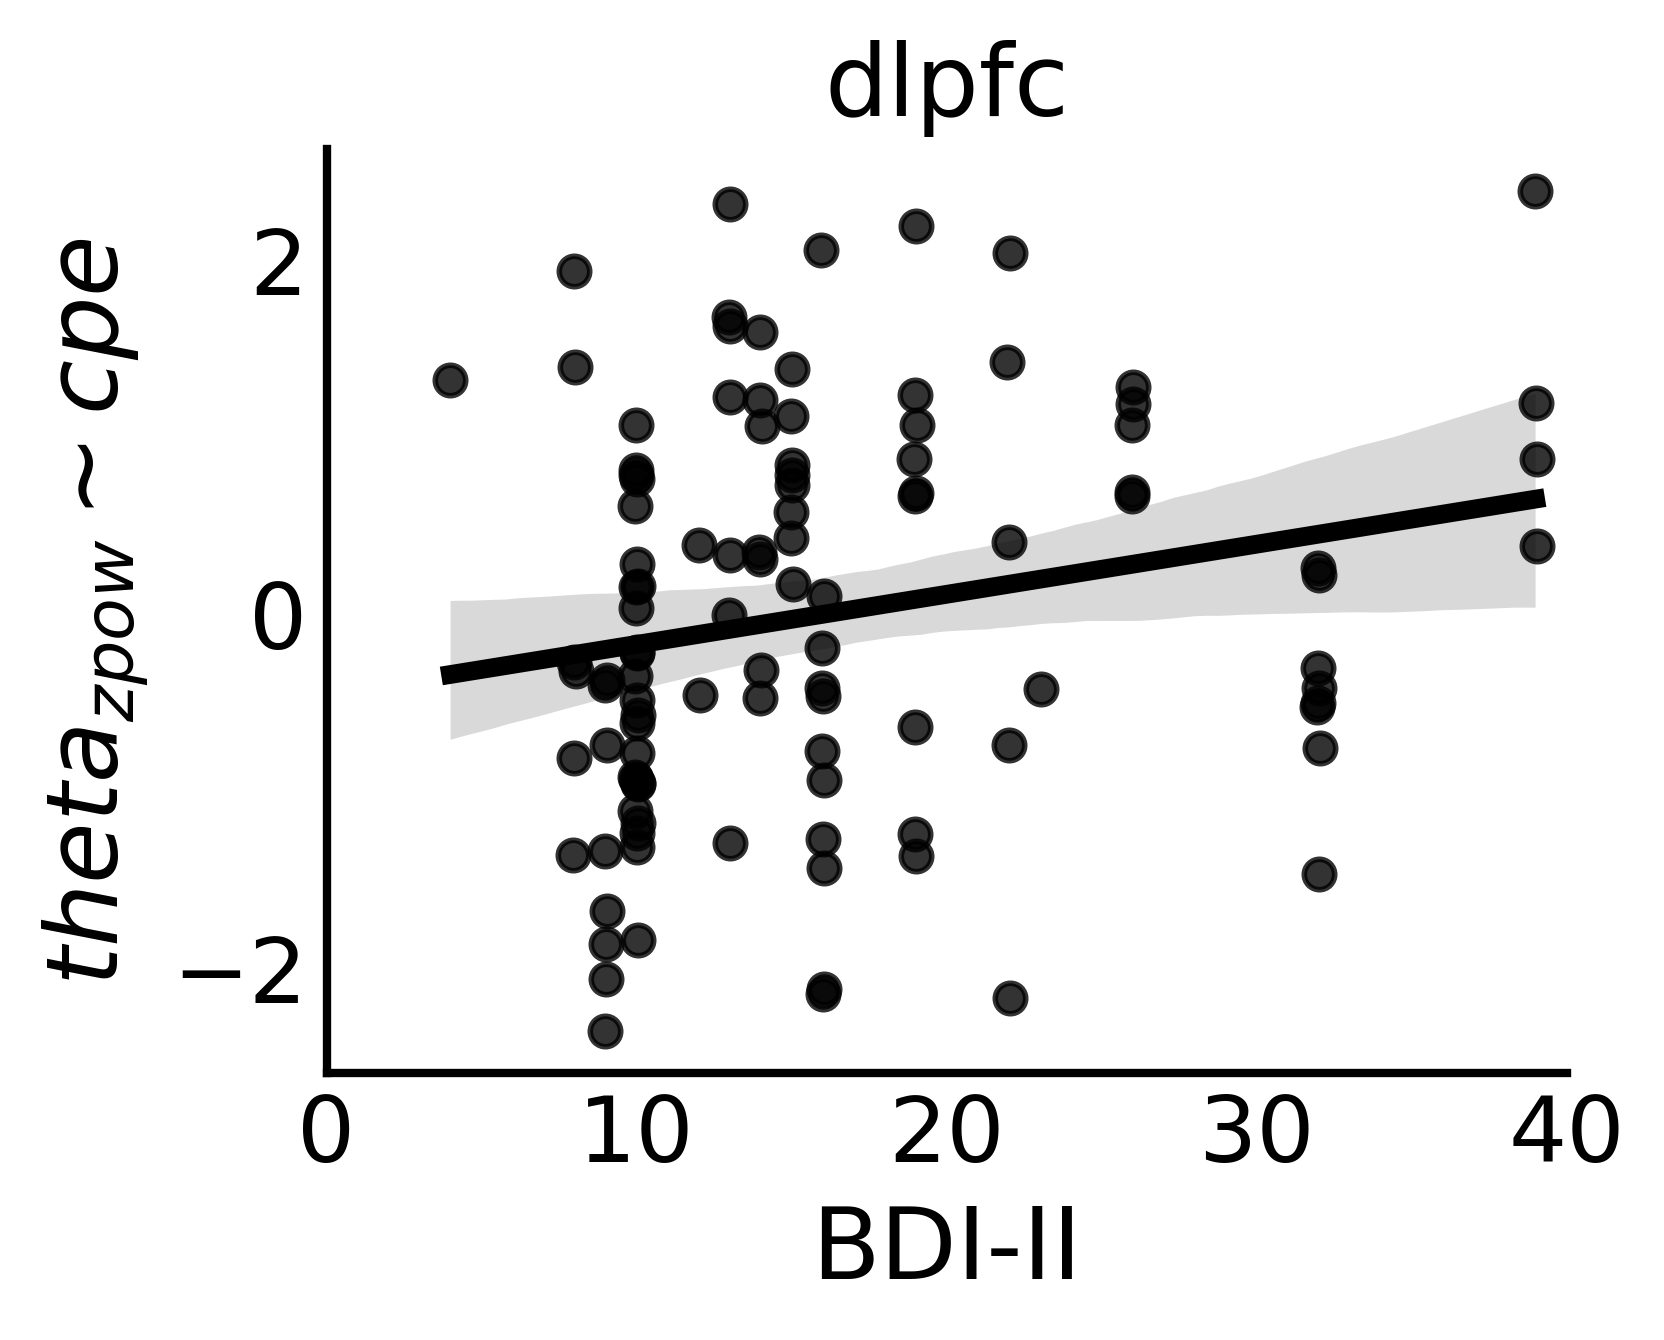

In [30]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_bdi_cpe-model_cpe_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_cpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [31]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 01 Oct 2024                                         
Time:                        10:26:01                                         
No. Iterations:                    10                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9358      0.456     34.968     